In [1]:
##Ref
##https://github.com/rubentea16/indo-bert-news-classification/blob/master/notebook/Indo_BERT_Fine_Tuning_News_Classification.ipynb
##https://towardsdatascience.com/how-to-train-bert-aaad00533168
##https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil --q
!pip install psutil --q
!pip install humanize --q
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.6 GB  | Proc size: 96.6 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [2]:
!pip install torch --q
import torch
import random
!pip install pandas --q
import pandas as pd
!pip install numpy --q
import numpy as np
!pip install sklearn --q
!pip install tqdm --q
!pip install transformers --q
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup, logging
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

     |████████████████████████████████| 4.9 MB 29.7 MB/s 
     |████████████████████████████████| 120 kB 68.7 MB/s 
     |████████████████████████████████| 6.6 MB 53.9 MB/s 


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:
from google.colab import files
import io
uploaded = files.upload() # upload train.csv & test.csv

train_set = pd.read_csv(io.BytesIO(uploaded['train.csv']), index_col=0)
test_set = pd.read_csv(io.BytesIO(uploaded['test.csv']))
train_set

Saving test.csv to test.csv
Saving train.csv to train.csv


,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,no
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,e100ss gini buka informasi sejelas nya identit...,yes
3,neng solo wes ono terduga corona cobo neng ati...,no
4,midiahn nii akun gak takut takut nya isu coron...,no
...,...,...
21596,depok panas ga karuan kereta sampe pasming huj...,no
21597,oxfara arie kriting yg lebi goblo nya orang ke...,no
21598,virus corona menyaba depok cuci tangan makan n...,no
21599,mata sipit tinggal depok udah abis dah bahan c...,no


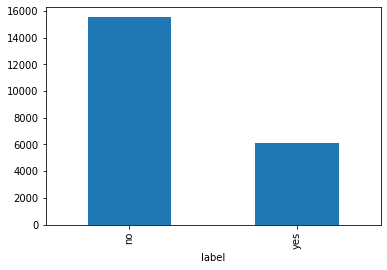

In [4]:
train_set.groupby(['label']).size().plot.bar()

In [5]:
logging.set_verbosity_error()

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model = BertModel.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [6]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text_a']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

labels = {'no':0,
          'yes':1}

In [7]:
df_train, df_val = train_test_split(train_set, test_size=0.2, random_state=42)

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [8]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=5, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=5)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
epochs = 5
model = BertClassifier()
learn = 1e-6

train(model, df_train, df_val, learn, epochs)

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

100%|██████████| 3456/3456 [26:58<00:00,  2.14it/s]


Epochs: 1 | Train Loss:  0.082                 | Train Accuracy:  0.818                 | Val Loss:  0.070                 | Val Accuracy:  0.854


100%|██████████| 3456/3456 [26:59<00:00,  2.13it/s]


Epochs: 2 | Train Loss:  0.061                 | Train Accuracy:  0.879                 | Val Loss:  0.063                 | Val Accuracy:  0.876


100%|██████████| 3456/3456 [26:59<00:00,  2.13it/s]


Epochs: 3 | Train Loss:  0.049                 | Train Accuracy:  0.912                 | Val Loss:  0.058                 | Val Accuracy:  0.888


100%|██████████| 3456/3456 [26:57<00:00,  2.14it/s]


Epochs: 4 | Train Loss:  0.036                 | Train Accuracy:  0.942                 | Val Loss:  0.059                 | Val Accuracy:  0.896


100%|██████████| 3456/3456 [26:57<00:00,  2.14it/s]


Epochs: 5 | Train Loss:  0.026                 | Train Accuracy:  0.962                 | Val Loss:  0.063                 | Val Accuracy:  0.891


In [15]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
test_set = pd.read_csv(io.BytesIO(uploaded['test.csv']))
evaluate(model, test_set)

Test Accuracy:  0.855


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
import pickle
pickle.dump(model, open('BERT-Fine Tuning.sav', 'wb'))
# model.save('BERT-Fine Tuning')

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [12]:
torch.save(model.state_dict(), 'BERT-Fine')